# Projektni zadatak iz dubokog učenja
### Aleksa Samardžija 2020/0488, Aleksa Đukić 2020/0161

### Opis problema i skupa podataka
Uzet je dataset koji u 10 klasa ima slike različitih vrsta divljih mačaka, gde nam je cilj da korišenjem konvolucionih neuralnih mreža raspoznamo kojoj klasi pripada svaka od njih. Slike su dimenzija 224x224x3.


### Učitavanje biblioteka, ulaznih podataka i podela na trening, validaciju i test

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import logging
tf.get_logger().setLevel(logging.ERROR)


import matplotlib.pyplot as plt
from keras import Sequential, layers, Model
from keras.layers import Dense, Normalization
from keras.utils import image_dataset_from_directory
from keras.optimizers.legacy import Adam, Adagrad
from keras.losses import SparseCategoricalCrossentropy  
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.regularizers import l2, l1

In [2]:
main_path = r"C:\Users\Aleksa\Desktop\NM teorija\projekat\dataset"
path = r"C:\Users\Aleksa\Desktop\NM teorija\projekat\test"
image_size = (224,224)
batch = 112

Xtrain = image_dataset_from_directory(main_path , subset='training', validation_split = 0.2, batch_size=batch,image_size= image_size,seed =123)
Xval = image_dataset_from_directory(main_path , subset='validation', validation_split = 0.2, batch_size=batch,image_size= image_size, seed= 123)
classes = Xtrain.class_names




Found 2339 files belonging to 10 classes.
Using 1872 files for training.
Found 2339 files belonging to 10 classes.
Using 467 files for validation.


Petinu podataka odvojili smo za validaciju, dok je ostatak podataka završio u trening skupu. Podela podataka je jako bitna ,jer da bismo efiaksno istrenirali model potrebno nam je da imamo dosta podataka u trening skupu. Takođe je jako bitno da ne stavimo i previše podataka na trening kako se naš model ne bi previše navikao na trening skupu i prilgaodio samo njemu, odnosno overfitt-ovao. Zato je jako bitno da u skup za validaciju ne smestimo premalo podataka. Krajnji je zaključak da je bitno da na treningu bude dosta, ali ne i previše podataka.

### Broj odbiraka svake klase i balansiranost klasa

In [3]:

Xtest = image_dataset_from_directory(path , batch_size=batch,image_size= image_size, seed= 123) #provera
class_counts = {class_name: 0 for class_name in classes}


for images, labels in Xtrain:
    for label in labels.numpy():
        class_name = classes[label]
        class_counts[class_name] += 1


for class_name, count in class_counts.items():
    print(f"Klasa {class_name}: {count} instanci")

Found 50 files belonging to 10 classes.


Klasa AFRICAN LEOPARD: 188 instanci
Klasa CARACAL: 186 instanci
Klasa CHEETAH: 195 instanci
Klasa CLOUDED LEOPARD: 180 instanci
Klasa JAGUAR: 193 instanci
Klasa LIONS: 184 instanci
Klasa OCELOT: 183 instanci
Klasa PUMA: 190 instanci
Klasa SNOW LEOPARD: 176 instanci
Klasa TIGER: 197 instanci


Možemo primetiti da sve od klase imaju prilično sličan broj odbiraka, te da naše klase nisu nebalansirane, pa u tom pogledu ne moramo vršiti dodatno predprocesiranje podataka.

### Primer svake od klase

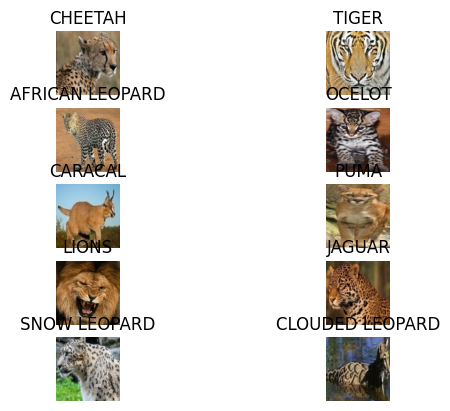

In [4]:
 
N = 10
c= []

plt.figure()
A =Xtrain.take(1)
for img, lab in Xtrain.take(1):
    i = 0
    j = 0
    while len(c)<10:
        if classes[lab[i]] not in c:
            c.append(classes[lab[i]])
            plt.subplot(int(N/2), 2, j+1)
            plt.imshow(img[i].numpy().astype('uint8'))
            plt.title(classes[lab[i]])
            plt.axis('off')
            j=j+1
        i = i+1
plt.show()

### Dotatno predprocesiranje podataka

Kako bismo dodatno proširili naš skup podataka i poboljšali trening, izvršićemo augmentaciju podataka u vidu rotacije, zumiranja i obrtanja.
Potom je izvršeno i reskaliranje svih piksela pa kao kompontentu metode za istu koristimo 1./255 pošto je reprezentacija slike u RGB.

In [5]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(image_size[0], 
                                                 image_size[1], 3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255 , input_shape=(224,224,3)))


Što se normalizacije tiče koristili smo batch normalizaciju posle konvolucionih slojeva.

### Model
Arhitektura modela je napravljena tako da naizmenično idu konvolucioni i pooling slojevi. Postoje 4 konvoluciona i 4 pooling sloja sa 2 fully-connected sloja. U konovlucionim slojevima je korišćen padding kako se u tim slojevima ne bi gubila informacija, ali je zato smanjivanje dimenzija i izvlačenje najjačih obeležja urađeno maxpooling-om. Što se aktivacionih funkcija tiče na poslednjem sloju je korišćen softmax, koji nam za instancu koja se klasifikuje, daje verovatnoće za pripadanje svakoj od klasa, dok je u ostalim slojevima korišćen ReLu. Bolje radi od sigmoida, zato što sigmoid vrlo brzo može da konvergira u 0, dok ReLu rešava taj problem.

In [6]:

model.add(layers.Conv2D(16, 3, padding="same" , activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding="same" , activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding="same" , activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, 3, padding="same" , activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())


model.add(layers.Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation = "softmax"))

model.summary()


model.compile(Adam(learning_rate=0.001), 
              loss = SparseCategoricalCrossentropy(),
              metrics='accuracy'
              )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)     

### Zaštita od preobučavanja
Preobučavanje neouralne mreže je pojava kod koje se mreža previše navikne na trening skup. Model je pretreniran onda kada preformanse na treniing skupu budu odlične, ali zato padaju na validaciji i testu. Kao metodu za prevenciju toga, koristili smo rano zaustavljanje, koje kada performanse na validaciji krenu da padaju, zaustavlja treiniranje i vraća model iz epohe u kojoj je do tad na validaciji bio najbolji. 

In [7]:
es = EarlyStopping( monitor= 'val_accuracy', patience= 25, restore_best_weights=True, start_from_epoch= 30)
history = model.fit(Xtrain,
                    epochs=100,
                    validation_data=Xval,
                    verbose=0,
                    callbacks=es)

### Grafici performansi kroz epohe na trening i validacionom skupu

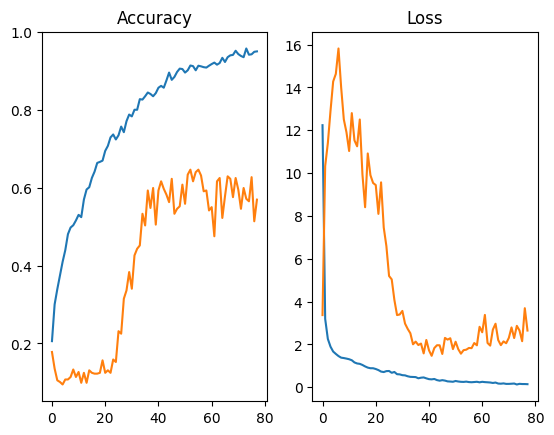

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.subplot(121)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.subplot(122)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.show()

### Matrice konfuzije na trening, test i validacionom skupu

Tačnost modela na treningu je: 88.72863247863248%


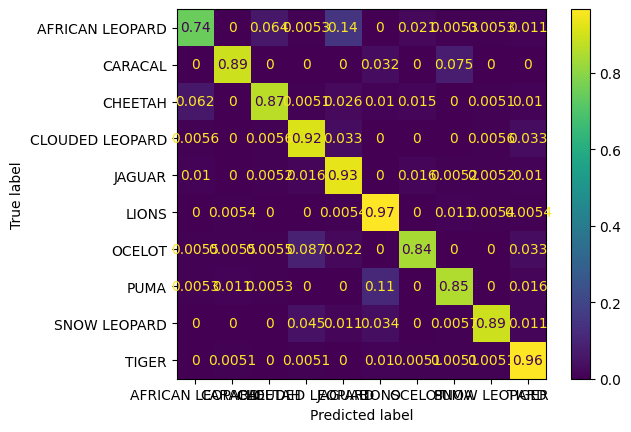

Tačnost modela na testu je: 70.0%


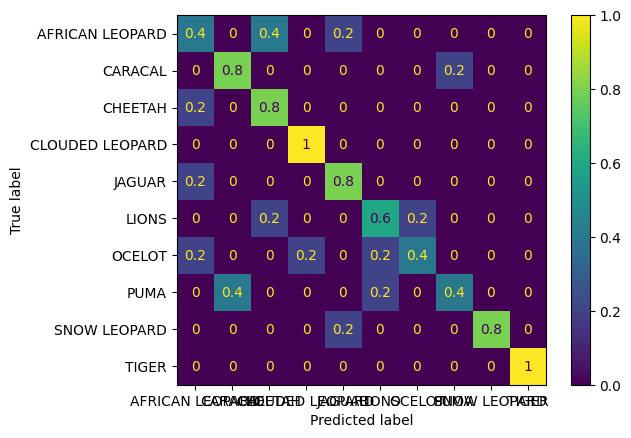

Tačnost modela na validaciji je: 64.66809421841542%


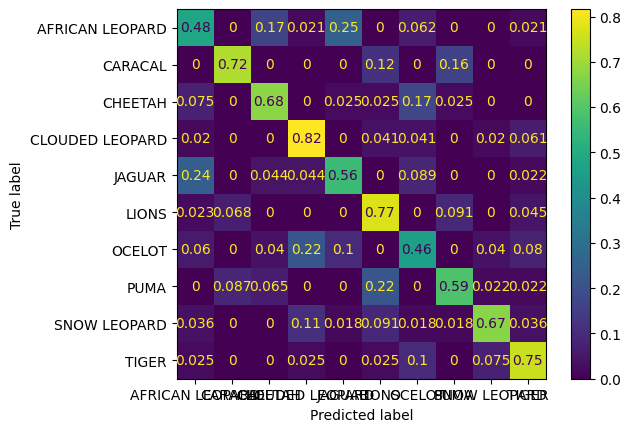

In [9]:
labels = np.array([])
pred = np.array([])
for img, lab in Xtrain:
    labels = np.append(labels, lab)
    pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))  

print('Tačnost modela na treningu je: ' + str(100*accuracy_score(labels, pred)) + '%')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, pred, normalize='true')
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot()
plt.show()
labels1 = np.array([])
pred1 = np.array([])
for img, lab in Xtest:
    labels1 = np.append(labels1, lab)
    pred1 = np.append(pred1, np.argmax(model.predict(img, verbose=0), axis=1))  

print('Tačnost modela na testu je: ' + str(100*accuracy_score(labels1, pred1)) + '%')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm1 = confusion_matrix(labels1, pred1, normalize='true')
cmDisplay1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=classes)
cmDisplay1.plot()
plt.show()
labels2 = np.array([])
pred2 = np.array([])
for img, lab in Xval:
    labels2 = np.append(labels2, lab)
    pred2 = np.append(pred2, np.argmax(model.predict(img, verbose=0), axis=1))  

print('Tačnost modela na validaciji je: ' + str(100*accuracy_score(labels2, pred2)) + '%')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm2 = confusion_matrix(labels2, pred2, normalize='true')
cmDisplay2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=classes)
cmDisplay2.plot()
plt.show()



### Primer dobre i loše klasifikacije

1/1 [==============================] - 0s 101ms/step
tf.Tensor(
[2 8 5 7 3 1 9 3 0 4 7 4 6 3 6 7 8 8 6 2 1 5 2 5 1 9 1 9 5 8 1 6 4 5 3 0 0
 9 4 3 7 9 4 2 2 7 0 0 6 8], shape=(50,), dtype=int32)


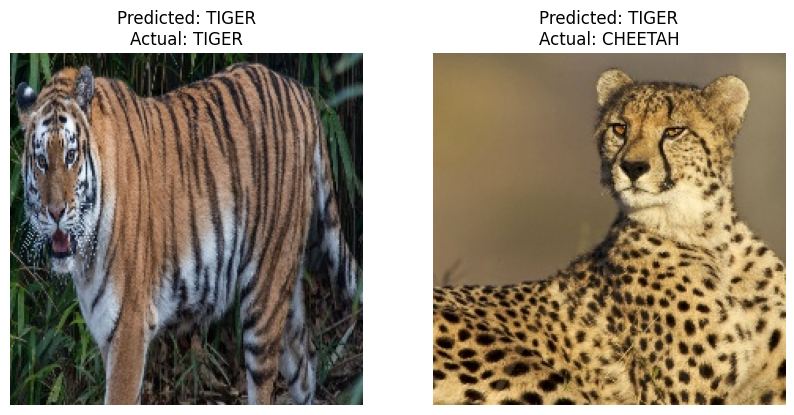

In [49]:
#Ytest = model.predict(Xtest, verbose= 0)
Ytest = []
Ytestimg = []

for img, lab in Xtest:
    Ytest.append(lab)
    Ytestimg.append(img)

Ytest = np.array(Ytest)
Ytestimg = np.array(Ytestimg)

Ytest = Ytest.astype(int)

predictions = model.predict(Xtest)
predicted_labels = np.argmax(predictions, axis=1)

Ytest = Ytest.T

correct_indices = np.where(predicted_labels.T == Ytest)[0]
incorrect_indices = np.where(predicted_labels.T != Ytest)[0]
     



plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
if len(correct_indices) > 0:
    for img, lab in Xtest:
        
        for idx in correct_indices:
            plt.imshow(img[idx].numpy().astype('uint8')) 
            plt.title(f'Predicted: {classes[predicted_labels[idx]]}\nActual: {classes[int(lab[idx])]}')  
            plt.axis('off')
            break  
        break  

plt.subplot(1, 2, 2)
if len(incorrect_indices) > 0:
    for img, lab in Xtest:
        print(lab)
        
        for idx in incorrect_indices:
            plt.imshow(img[idx].numpy().astype('uint8'))  
            plt.title(f'Predicted: {classes[predicted_labels[idx]]}\nActual: {classes[int(lab[idx])]}')  
            plt.axis('off')
            break  
        break  

plt.show()
